In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import scipy
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

tfd = tfp.distributions

## ADDING UNCERTAINTY TO NEURAL NETWORK REGRESSION TASKS IN THE GEOSCIENCES

https://arxiv.org/pdf/2109.07250.pdf


This is broken during the model.fit part. Alas.


In [2]:
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [3]:
# Loss function

def RegressLossExpSigma(y_true , y_pred): 
    mu = y_pred[:, 0]
    std = tf.math.exp(y_pred[:, 1]) 
    skew = y_pred[:, 2]
    tau = tf.math.exp(y_pred[:, 3])
    cond_dist = tfp.distributions.SinhArcsinh(loc=mu, scale=std, skewness=skew, tailweight=tau)
    loss = -cond_dist.log_prob(y_true[:, 0])
    return tf.reduce_mean(loss, axis=-1)

In [4]:
"""sinh-arcsinh normal distribution helper functions.
Functions
---------
mean(mu, sigma, gamma, tau)
distribution mean.
median(mu, sigma, gamma, tau) distribution median.
stddev(mu, sigma, gamma, tau) distribution standard deviation.
variance(mu, sigma, gamma, tau) distribution variance.
Notes
-----
* The sinh-arcsinh normal distribution was defined in [1]. A more accessible presentation is given in [2].
* The notation and formulation used in this code was taken from [3], page 143. In the gamlss.dist/CRAN package the distribution is called SHASHo.
* There is a typographical error in the presentation of the probability density function on page 143 of [3]. There is an extra "2" in the denomenator preceeding the "sqrt{1 + z^2}" term.
References
----------
[1] Jones, M. C. & Pewsey, A., Sinh-arcsinh distributions, Biometrika, Oxford University Press, 2009, 96, 761-780. DOI: 10.1093/biomet/asp053.
[2] Jones, C. & Pewsey, A., The sinh-arcsinh normal distribution, Significance, Wiley, 2019, 16, 6-7.
DOI: 10.1111/j.1740-9713.2019.01245.x. https://rss.onlinelibrary.wiley.com/doi/10.1111/j.1740-9713.2019.01245.x
[3] Stasinopoulos, Mikis, et al. (2021), Distributions for Generalized Additive Models for Location Scale and Shape, CRAN Package. https://cran.r-project.org/web/packages/gamlss.dist/gamlss.dist.pdf
"""
import numpy as np 
import scipy
import tensorflow as tf

__author__ = "Randal J. Barnes and Elizabeth A. Barnes" 
__date__ = "10 September 2021"
def _jones_pewsey_P(q):
    """P_q function from page 764 of [1].
    
    This is a module private helper function. This function will not be called externally.

    Arguments
    ---------
    q : float or double, array like
    
    Returns
    -------
    P_q : array like of same shape as
    
    Notes
    -----
    * The strange constant 0.25612... 
    is "sqrt( sqrt(e) / (8*pi) )" computed with a high-precision calculator.
    """
    return 0.25612601391340369863537463 * (
        scipy.special.kv((q + 1) / 2, 0.25) + scipy.special.kv((q - 1) / 2, 0.25)
    )

def mean(mu, sigma, gamma, tau): 
    """The distribution mean.
    
    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.
    
    sigma : float or double (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same shape and dtype as mu.

    gamma : float or double (batch size x 1) Tensor
        The skewness parameter. Must be the same shape and dtype as mu.

    tau : float or double (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same shape and dtype as mu.

    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values.
    """
    evX = tf.math.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau) 
    return mu + sigma * evX

def median(mu, sigma, gamma, tau): 
    """The distribution median.
    
    Arguments
    ---------

    mu : float or double (batch size x 1) Tensor
        The location parameter.

    sigma : float or double (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same shape and dtype as mu.

    gamma : float or double (batch size x 1) Tensor
        The skewness parameter. Must be the same shape and dtype as mu.

    tau : float or double (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same shape and dtype as mu.
    
    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values.
    
    Notes
    -----
    * This code uses the basic formula:
    
        E(a*X + b) = a*E(X) + b
        
    * The E(X) is computed using the moment equation given on page 764 of [1].
    
    """
    
    return mu + sigma * tf.math.sinh(gamma / tau)

def stddev(mu, sigma, gamma, tau):
    """The distribution standard deviation.
    
    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.

    sigma : float or double (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same shape and dtype as mu.

    gamma : float or double (batch size x 1) Tensor
        The skewness parameter. Must be the same shape and dtype as mu.

    tau : float or double (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same shape and dtype as mu.
    
    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values. """
    return tf.math.sqrt(variance(mu,sigma, gamma, tau))

                                 
def variance(mu, sigma, gamma, tau): 
    """The distribution variance.
    Arguments
    ---------
    mu : float or double (batch size x 1) Tensor
        The location parameter.

    sigma : float or double (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same shape and dtype as mu.

    gamma : float or double (batch size x 1) Tensor
        The skewness parameter. Must be the same shape and dtype as mu.

    tau : float or double (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same shape and dtype as mu.
        
    Returns
    -------
    x : float or double (batch size x 1) Tensor.
        The computed distribution mean values.

    Notes
    -----
    * This code uses two basic formulas:

        var(X) = E(X^2) - (E(X))^2 
        var(a*X + b) = a^2 * var(X)

    * The E(X) and E(X^2) are computed using the moment equations given on page 764 of [1].
    """
    evX = tf.math.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)
    evX2 = (tf.math.cosh(2 * gamma / tau) * _jones_pewsey_P(2.0 / tau) - 1.0) / 2

    return tf.math.square(sigma) * (evX2 - tf.math.square(evX))

In [5]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal , Zeros

INPUT_SHAPE = 1 
N_HIDDENS = 10 
SEED = 99

inputs = tf.keras.Input(shape=INPUT_SHAPE) 
x = inputs

# initialize a single hidden layer
x = tf.keras.layers.Dense(
    N_HIDDENS,
    activation="relu",
    use_bias=True,
    bias_initializer=RandomNormal(seed=SEED),
    kernel_initializer=RandomNormal(seed=SEED),
)(x)

# set final output units separately
mu_unit = tf.keras.layers.Dense( 
    1,
    activation="linear",
    use_bias=True, 
    bias_initializer=RandomNormal(seed=SEED), 
    kernel_initializer=RandomNormal(seed=SEED),
)(x)

logsigma_unit = tf.keras.layers.Dense( 
    1,
    activation="linear", 
    use_bias=True, 
    bias_initializer=Zeros(), 
    kernel_initializer=Zeros(),
)(x)

skew_unit = tf.keras.layers.Dense( 
    1,
    activation="linear", 
    use_bias=True, 
    bias_initializer=Zeros(), 
    kernel_initializer=Zeros(),
)(x)

logtau_unit = tf.keras.layers.Dense( 
    1,
    activation="linear", 
    use_bias=True, 
    bias_initializer=Zeros(), 
    kernel_initializer=Zeros(),
)(x)

# final output layer
output_layer = tf.keras.layers.concatenate(
    [mu_unit , logsigma_unit , skew_unit , logtau_unit], axis=1
)
# finalize the model
model = tf.keras.models.Model(inputs=inputs , outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           20          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            11          dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            11          dense[0][0]                      
______________________________________________________________________________________________

In [6]:
gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")

In [7]:
xname="sm_0.67"; yname="halo_mass"
xname="stellarmass"; yname="halo_mass"
x=cluster_data[xname]; 
y=cluster_data[yname];

unit_df =pd.DataFrame(data={"x":x,"y":y}) 
print(unit_df.shape)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(unit_df)

# Remove outliers.
detector = IsolationForest(n_estimators=1000,  contamination=0.15, random_state=0)
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]

inv_df=pd.DataFrame(data={xname:X_t[:,0],yname:X_t[:,1]})
X_t = scaler.inverse_transform(inv_df)
xc=X_t[:,0]
yc=X_t[:,1]

(287, 2)


In [12]:
# Do inference.

#negloglik = lambda y, rv_y: -rv_y.log_prob(y)
def neg_log_likelihood(y_true, y_pred):
    y_pred = tfp.distributions.MultivariateNormalTriL(y_pred)
    return -tf.reduce_mean(y_pred.log_prob(y_true))

model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01), loss=neg_log_likelihood)
model.fit(xc, yc, epochs=100, verbose=False);

In [13]:
# Profit.
x_tst=np.arange(x.min(),x.max(),0.1)
x_tst=x_tst[:,None]

[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)

assert isinstance(yhat, tfd.Distribution)

[-0.38338778 -0.3691231  -0.02799833 -0.00291349 -0.38127735 -0.38714766
 -0.38424722 -0.021693   -0.10551486 -0.37322165]
[ 0.4626678   0.4895578  -0.02799833 -0.00291349  0.46730677  0.44461903
  0.46058902 -0.021693   -0.10551486  0.48247582]
[ 0.1438638   0.15527004 -0.02799833 -0.00291349  0.14591673  0.13414337
  0.14291608 -0.021693   -0.10551486  0.15232922]
14.178117982172152
[0.14962248 0.13385875 0.         0.         0.14709603 0.15721711
 0.15070936 0.         0.         0.13820524]
14.178114864402437
[0.14962248 0.13385875 0.         0.         0.14709603 0.15721711
 0.15070936 0.         0.         0.13820524]
14.178114864402437
[0.14962248 0.13385875 0.         0.         0.14709603 0.15721711
 0.15070936 0.         0.         0.13820524]
14.178114864402437


AssertionError: 

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

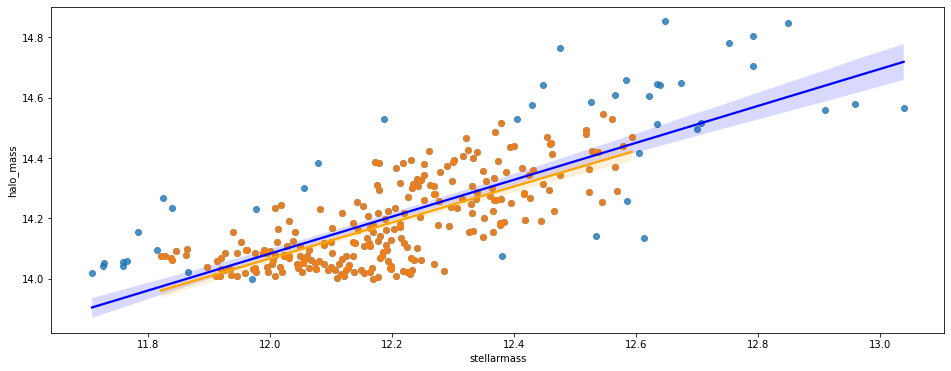

In [11]:
inv_df=pd.DataFrame(data={xname:X_t[:,0],yname:X_t[:,1]})
sns.regplot(x=xname,y=yname, data=cluster_data, line_kws={"color": "blue"})
sns.regplot(x=xname,y=yname, data=inv_df, line_kws={"color": "orange"})

plt.plot(x_tst, yhat.mean(),'purple', label='mean', linewidth=3);
plt.plot(x_tst, yhat.quantile(0.32),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.68),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.10),'g',linewidth=0.5);
plt.plot(x_tst, yhat.quantile(0.90),'g',linewidth=0.5);